In [3]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import random
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import tqdm
from torchvision import transforms

In [4]:

def load_flickr30k_data(base_image_dir, caption_file):
    """
    解析本地 Flickr30k 数据集。
    :param image_dir: 图像文件夹路径
    :param caption_file: 包含图像名称和对应描述的文件路径
    :return: 列表 [{ "image": 图像路径, "text": 描述 }]
    """
    data = []
    caption_df = pd.read_csv(caption_file)
    # 遍历每一行
    for index, row in caption_df.iterrows():
        image_name = row["image_name"]
        caption = row["comment"]
        image_path = os.path.join(base_image_dir, image_name)
        data.append({"image": image_path, "text": caption})
    return data

def display_image_caption_pairs(dataset, num_pairs=15):
    """
    显示图像和描述对。
    :param dataset: 数据集
    :param num_pairs: 要显示的图像和描述对的数量
    """
    plt.figure(figsize=(20, 20))
    for i in range(num_pairs):
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        pair = random.choice(dataset)
        image_path = pair["image"]
        caption = pair["text"]
        image = Image.open(image_path)
        # resize image
        image = image.resize((224, 224))
        max_char_per_line = 20
        caption = "\n".join([caption[j:j + max_char_per_line] for j in range(0, len(caption), max_char_per_line)])
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(caption)
        plt.axis("off")
    plt.show()

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        images = Image.open(item["image"])
        # 处理图像
        encoding = self.processor(images=images, text=item["text"], padding="max_length", return_tensors="pt")
        # 移除批处理维度
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        return encoding

In [5]:
image_dir = r"D:\pyproject\representation_learning_models\dataset_utils\flickr_30k\flickr30k_images"
caption_file = r"D:\pyproject\representation_learning_models\dataset_utils\flickr_30k\captions.txt"
data = load_flickr30k_data(image_dir, caption_file)



quant_config = BitsAndBytesConfig(load_in_8bit=True)
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = AutoModelForImageTextToText.from_pretrained("Salesforce/blip-image-captioning-base")

In [6]:
def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


def train(model, dataloader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            image = batch["pixel_values"].to(device)
            attn_mask = batch["attention_mask"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, pixel_values=image, labels=input_ids, attention_mask=attn_mask)
            loss = outputs.loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update loss and progress bar
            total_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Print epoch summary
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        # model prediction
        model.eval()
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]

        # 定义逆归一化函数
        unnormalize = transforms.Normalize(
            mean=[-m / s for m, s in zip(mean, std)],
            std=[1 / s for s in std]
        )
        for batch in dataloader:
            pixel_values = batch["pixel_values"]
            pixel_values = pixel_values.to(device)

            predict_idx = model.generate(pixel_values=pixel_values, max_length=32)
            predictions = processor.batch_decode(predict_idx, skip_special_tokens=True)

            # 绘制图片和对应的文本
            for i in range(4):
                #image = Image.fromarray(pixel_values[i].detach().cpu().numpy().astype("uint8").transpose(1, 2, 0))
                unnormalized_image = unnormalize(pixel_values[i])
                unnormalized_image = unnormalized_image.permute(1, 2, 0).cpu().numpy()  # 转换到 (H, W, 3)
                unnormalized_image = (unnormalized_image * 255).clip(0, 255).astype("uint8")  # [0, 255]
                reconstructed_image = Image.fromarray(unnormalized_image)
                plt.imshow(reconstructed_image)
                plt.title(predictions[i])
                plt.axis("off")
                plt.show()

            break


    return model

trainable params: 1,179,648 || all params: 248,593,724 || trainable%: 0.4745


Epoch 1/100: 100%|██████████| 32/32 [00:15<00:00,  2.10batch/s, Loss=9.3] 


Epoch 1/100, Average Loss: 10.7397


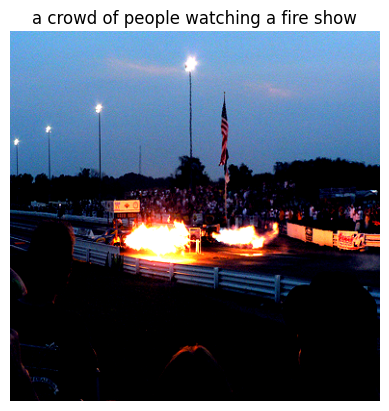

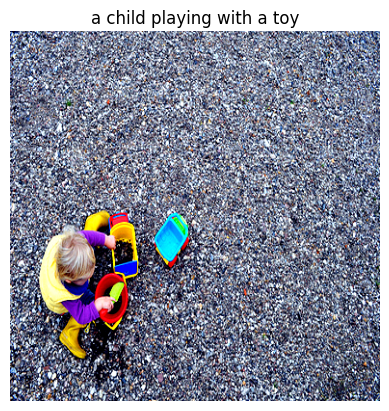

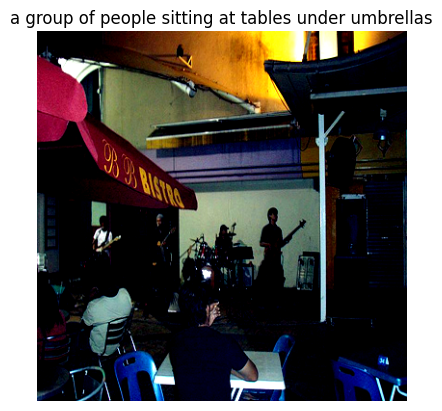

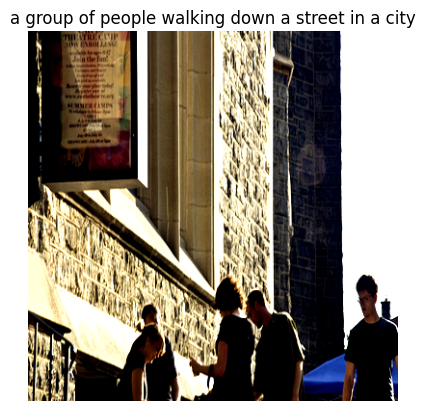

Epoch 2/100: 100%|██████████| 32/32 [00:15<00:00,  2.13batch/s, Loss=8.86]


Epoch 2/100, Average Loss: 9.0861


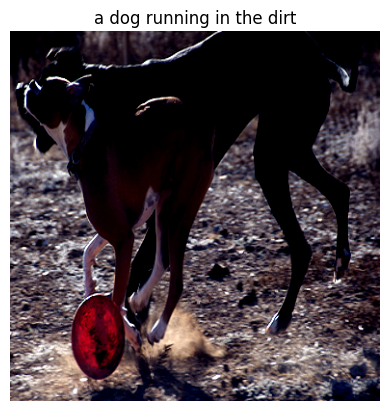

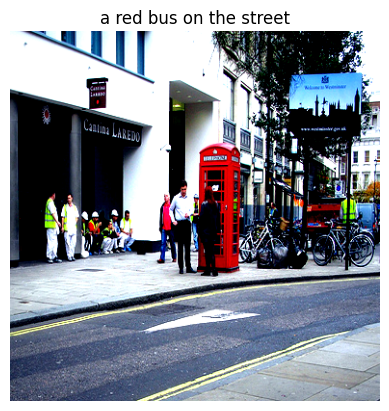

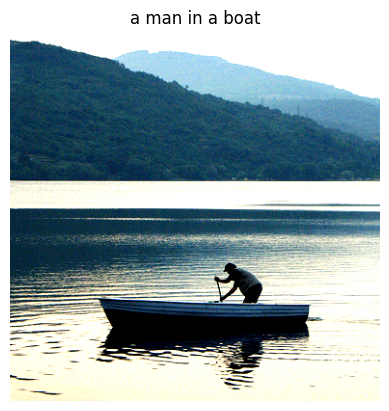

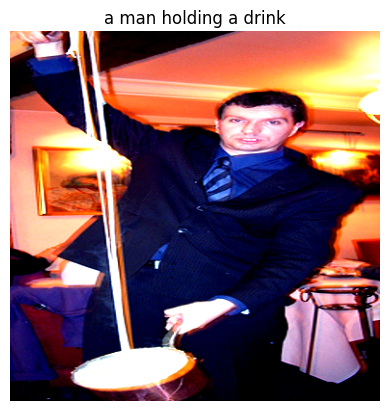

Epoch 3/100:  31%|███▏      | 10/32 [00:04<00:10,  2.09batch/s, Loss=8.82]


ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [7]:


dataset = ImageCaptioningDataset(data, processor)
sample_size = 500  # 样本数量
indices = random.sample(range(len(dataset)), sample_size)  # 随机选取样本索引
subset = Subset(dataset, indices)  # 使用 Subset 创建子集

dataloader = DataLoader(subset, batch_size=16, shuffle=True, collate_fn=collate_fn)


# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "key"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trained_model = train(model, dataloader, num_epochs=100)